In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset, is_uniform, infer_freq
from gluonts.dataset.split import split
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_single, plot_next_multi

from mov_av import moving_average

In [2]:
# data_2023 = pd.read_csv('data/load_values_23.csv', delimiter='\t')
# data_2023 = data_2023.query("CountryCode == 'GR'").reset_index()
# data_2023 = data_2023.drop(["CreateDate", "UpdateDate", "CountryCode", "index", 
#                   "MeasureItem", "DateShort", "TimeFrom", "TimeTo",
#                   "Cov_ratio", "Value_ScaleTo100"], axis=1)
# data_2023['DateUTC'] = pd.to_datetime(data_2023['DateUTC'], dayfirst=True)
# data_2023.iloc[2018, 0] = pd.Timestamp(2023, 3, 26, 2)

# data_2024 = pd.read_csv('data/load_values_24.csv')
# data_2024 = data_2024.query("CountryCode == 'GR'").reset_index()
# data_2024 = data_2024.drop(["CreateDate", "UpdateDate", "CountryCode", "index", 
#                   "MeasureItem", "DateShort", "TimeFrom", "TimeTo",
#                   "Cov_ratio", "Value_ScaleTo100"], axis=1)
# data_2024['DateUTC'] = pd.to_datetime(data_2024['DateUTC'], dayfirst=True)
# data_2024.loc[len(data_2024.index)] = [pd.Timestamp(2024, 3, 31, 2), data_2024['Value'].mean()]
# data_2024.loc[len(data_2024.index)] = [pd.Timestamp(2024, 3, 31, 3), data_2024['Value'].mean()]
# data_2024 = data_2024.sort_values('DateUTC')

# pd.concat([data_2023, data_2024]).to_csv("data/gr_load_data_23_24.csv", index=False)

In [3]:
SZ = 'small'
PDT = 7 * 24  # prediction length: any positive integer
CTX = 1 * ((4 * PDT) + 48)  # context length: any positive integer
PSZ = 64  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = PDT  # batch size: any positive integer
TEST = 6 * ((4 * PDT) + 48) # test set length: any positive integer

HISTORY = CTX
NUM_WINDOWS = TEST // PDT
DIST = PDT

In [4]:
TEST

4320

In [5]:
moirai = MoiraiModule.from_pretrained(f"moirai_{SZ}_weights")

Loading weights from local directory


In [6]:
data = pd.read_csv("data/gr_load_data_23_24.csv")
data = data.iloc[8760-CTX:8760+TEST, :]
data = data.drop_duplicates('DateUTC')
data['DateUTC'] = pd.to_datetime(data['DateUTC'])
data = data.set_index('DateUTC')
# data.to_csv('monthly_hourly_load_values_2024_processed.csv')

In [7]:
data.shape

(5040, 1)

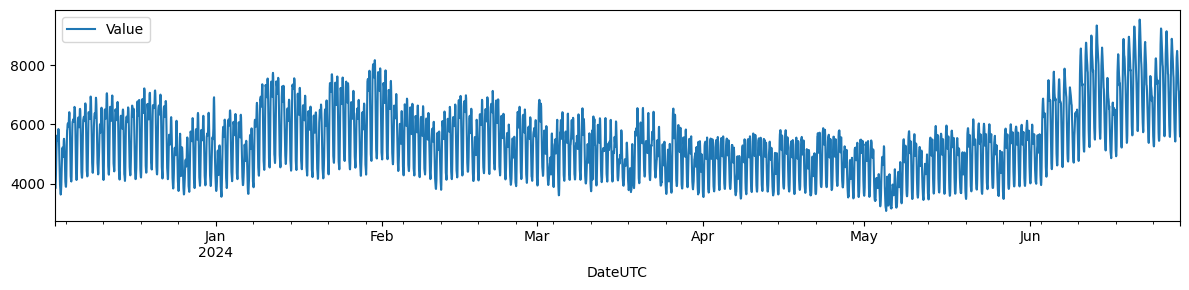

In [8]:
data.plot(figsize=(12, 3))
plt.tight_layout();

In [9]:
# Prepare model
model = MoiraiForecast(
    module=moirai,
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=200,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

In [10]:
ds = PandasDataset(data, target='Value', freq='H')

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=NUM_WINDOWS,  # number of windows in rolling window evaluation
    distance=DIST, # number of time steps between each window - distance=PDT for non-overlapping windows
    max_history=HISTORY
)

In [40]:
from uni2ts.alex.common.benchmark_func import *

forecast_samples, target_values = get_eval_foreasts(model, test_data)

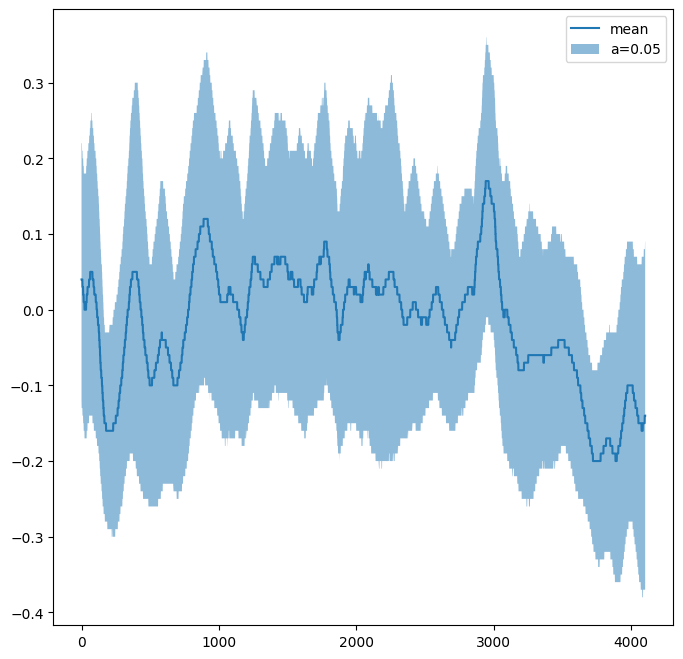

In [103]:
mean_error = (np.mean(forecast_samples, axis=1).flatten() - target_values.flatten())/target_values.flatten()
upper_error = (np.quantile(forecast_samples, 0.975, axis=1).flatten() - target_values.flatten())/target_values.flatten()
lower_error = (np.quantile(forecast_samples, 0.025, axis=1).flatten() - target_values.flatten())/target_values.flatten()

window_size = 96
mean_error_ma = moving_average(np.array(mean_error), window_size)
upper_error_ma = moving_average(np.array(upper_error), window_size)
lower_error_ma = moving_average(np.array(lower_error), window_size)

plt.figure(figsize=(8, 8))
plt.plot(
    mean_error_ma,
    label="mean",
)

plt.fill_between(
    range(0, 25*168 - window_size + 1),
    lower_error_ma,
    upper_error_ma,
    alpha=0.5,
    label="a=0.05",
)
plt.legend();

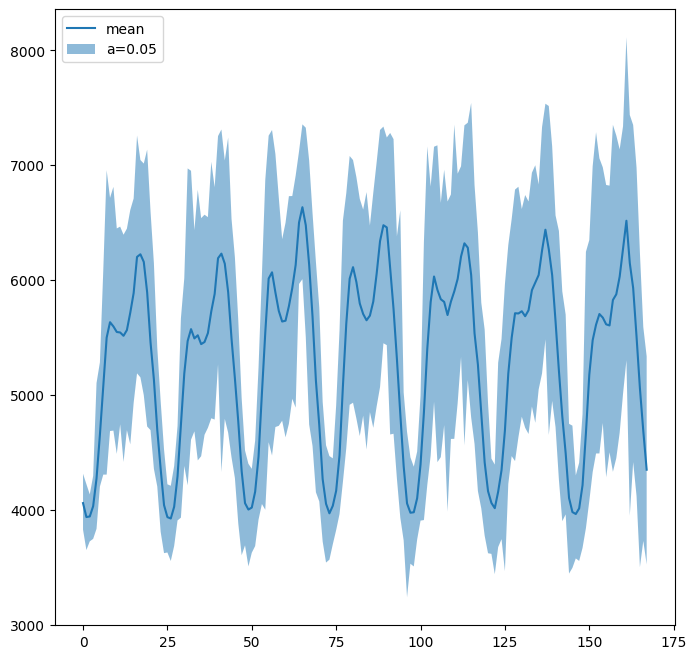

In [70]:
plt.figure(figsize=(8, 8))
plt.plot(
    np.mean(forecast_samples, axis=1).flatten()[:168],
    label="mean",
)

plt.fill_between(
    range(0, 168),
    np.quantile(forecast_samples, 0.025, axis=1).flatten()[:168],
    np.quantile(forecast_samples, 0.975, axis=1).flatten()[:168],
    alpha=0.5,
    label="a=0.05",
)
plt.legend();

In [26]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [24]:
errors = []
for i in range(NUM_WINDOWS):
    try:
        label = next(label_it)['target']
        forecast = next(forecast_it).mean
    except Exception as e:
        print(e)
        break

    errors.append(np.mean(np.abs(label-forecast)))

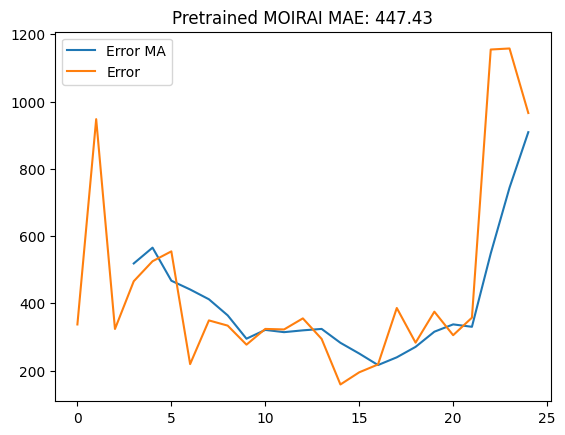

In [25]:
window_size = 4
plt.title(f"Pretrained MOIRAI MAE: {np.round(np.mean(errors), 2)}")
plt.plot(range(window_size-1,len(errors)), moving_average(np.array(errors), window_size), label='Error MA')
plt.plot(range(len(errors)), errors, label='Error')
plt.legend()
plt.savefig("pretrained_moirai_mae.png");

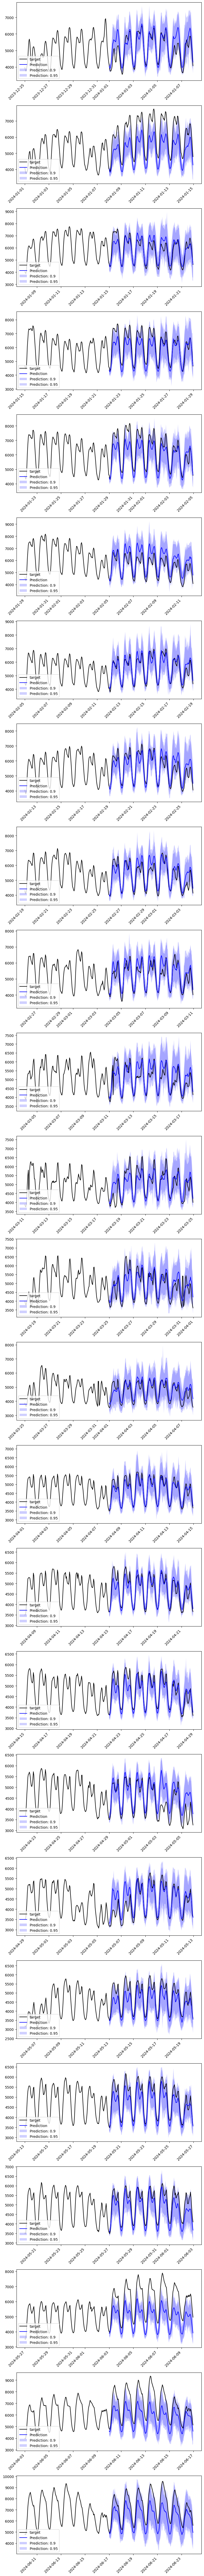

In [26]:
# Make predictions
if NUM_WINDOWS <= 30:
    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)
    
    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)
    
    fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, NUM_WINDOWS * 4))
    plot_next_multi(
        axes,
        input_it,
        label_it,
        forecast_it,
        context_length=1 * PDT,
        intervals=(0.9, 0.95),
        dim=None,
        name="Prediction",
        show_label=True,
    )
    plt.tight_layout()

    plt.savefig("pretrained_moirai_predictions.png");

In [27]:
experiment_run = "champion"
os.listdir(f"outputs/finetune/moirai_1.0_R_small/Load_Data/{experiment_run}/checkpoints/")

['epoch=20-step=3780.ckpt']

In [28]:
experiment_run = "champion"
checkpoint = os.listdir(f"outputs/finetune/moirai_1.0_R_small/Load_Data/{experiment_run}/checkpoints/")[-1]

print(f"Checkpoint: {checkpoint}")

fine_tuned_model = MoiraiForecast.load_from_checkpoint(
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=200,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
    checkpoint_path=f"outputs/finetune/moirai_1.0_R_small/Load_Data/{experiment_run}/checkpoints/{checkpoint}"
)

Checkpoint: epoch=20-step=3780.ckpt


In [29]:
predictor = fine_tuned_model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [30]:
finetuned_errors = []
for i in range(NUM_WINDOWS):
    try:
        label = next(label_it)['target']
        forecast = next(forecast_it).mean
    except Exception as e:
        print(e)
        break

    finetuned_errors.append(np.mean(np.abs(label-forecast)))

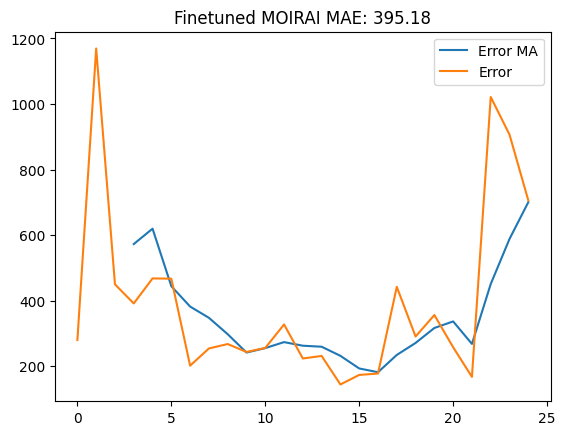

In [31]:
window_size = 4
plt.title(f"Finetuned MOIRAI MAE: {np.round(np.mean(finetuned_errors), 2)}")
plt.plot(range(window_size-1,len(errors)), moving_average(np.array(finetuned_errors), window_size), label='Error MA')
plt.plot(range(len(finetuned_errors)), finetuned_errors, label='Error')
plt.legend()
plt.savefig("finetuned_moirai_mae.png");

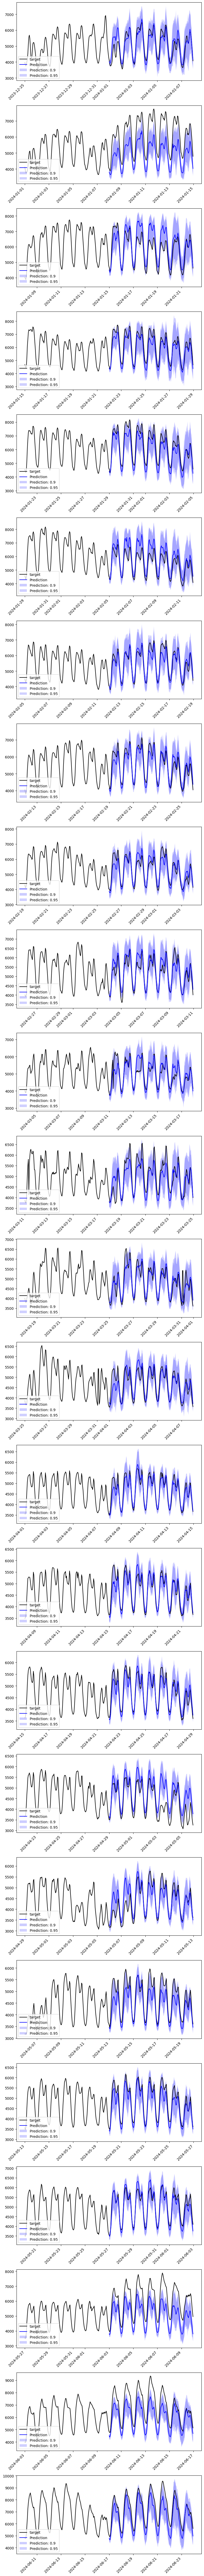

In [32]:
# Make predictions
if NUM_WINDOWS <= 30:
    predictor = fine_tuned_model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)
    
    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)
    
    fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, NUM_WINDOWS * 4))
    plot_next_multi(
        axes,
        input_it,
        label_it,
        forecast_it,
        context_length=1 * PDT,
        intervals=(0.9, 0.95),
        dim=None,
        name="Prediction",
        show_label=True,
    )
    plt.tight_layout()
    plt.savefig("finetuned_moirai_predictions.png");

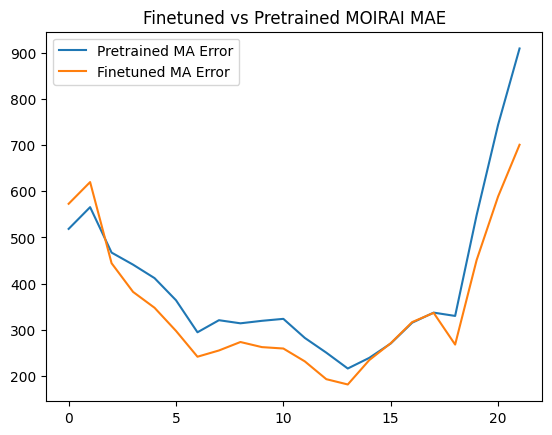

In [33]:
window_size = 4
plt.title("Finetuned vs Pretrained MOIRAI MAE")
plt.plot(range(len(moving_average(np.array(errors), window_size))), 
         moving_average(np.array(errors), window_size), label='Pretrained MA Error')
plt.plot(range(len(moving_average(np.array(finetuned_errors), window_size))), 
         moving_average(np.array(finetuned_errors), window_size), label='Finetuned MA Error')
plt.legend();

In [34]:
# plt.title("Finetuned vs Pretrained MOIRAI MAE")
# plt.plot(range(len(errors)), errors, label='Pretrained Error')
# plt.plot(range(len(finetuned_errors)), finetuned_errors, label='Finetuned Error')
# plt.legend();

In [35]:
from uni2ts.eval_util.evaluation import evaluate_model
from gluonts.ev.metrics import MAE, MAPE

In [36]:
metrics = []
for perc in [0.025, 0.05, 0.1, 0.5, 0.9, 0.95, 0.975]:
    metric_eval = evaluate_model(
        model = fine_tuned_model.create_predictor(batch_size=BSZ),
        test_data = test_data,
        metrics = [MAE(perc), MAPE(perc)]
    )

    metrics.append(metric_eval)

pd.concat(metrics, axis=1)

25it [00:01, 16.77it/s]
25it [00:01, 17.18it/s]
25it [00:01, 17.13it/s]
25it [00:01, 17.18it/s]
25it [00:01, 17.17it/s]
25it [00:01, 16.82it/s]
25it [00:01, 17.15it/s]


MAE[0.025]  MAPE[0.025]   MAE[0.05]  MAPE[0.05]    MAE[0.1]  MAPE[0.1]  \
None  923.279896     0.161938  804.811296    0.140465  678.579776   0.117785   

       MAE[0.5]  MAPE[0.5]    MAE[0.9]  MAPE[0.9]   MAE[0.95]  MAPE[0.95]  \
None  393.07118   0.070076  478.400795   0.091282  560.240453    0.107721   

      MAE[0.975]  MAPE[0.975]  
None  644.671806     0.124459

In [37]:
metrics = []
for perc in [0.025, 0.05, 0.1, 0.5, 0.9, 0.95, 0.975]:
    metric_eval = evaluate_model(
        model = model.create_predictor(batch_size=BSZ),
        test_data = test_data,
        metrics = [MAE(perc), MAPE(perc)]
    )

    metrics.append(metric_eval)

pd.concat(metrics, axis=1)

25it [00:01, 16.30it/s]
25it [00:01, 16.43it/s]
25it [00:01, 16.37it/s]
25it [00:01, 16.24it/s]
25it [00:01, 16.34it/s]
25it [00:01, 16.20it/s]
25it [00:01, 16.29it/s]


MAE[0.025]  MAPE[0.025]   MAE[0.05]  MAPE[0.05]    MAE[0.1]  MAPE[0.1]  \
None  1088.400247      0.18998  900.204572    0.155682  723.756424   0.124106   

        MAE[0.5]  MAPE[0.5]    MAE[0.9]  MAPE[0.9]   MAE[0.95]  MAPE[0.95]  \
None  443.608622   0.078769  562.842636   0.109578  696.376193     0.13714   

      MAE[0.975]  MAPE[0.975]  
None  867.341357      0.17111